In [180]:
from os import listdir
from os.path import isdir, join
import yaml
DATA_DIR = 'data'
PRO_DIR = 'pro_spaces_modified_cone'

expers = [f for f in listdir(DATA_DIR) if isdir(join(DATA_DIR, f))]
expers

['big_c',
 'small_targ',
 'big_w',
 'test',
 'small_c',
 'data_set2',
 'test1',
 'zero_c',
 'big_iters',
 'smaller_orbs',
 'mod_cone',
 'data_set1',
 'small_orbs']

In [179]:
SELECTED_EXPER = "big_w"


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

EXPER_NAME = ''
if type(SELECTED_EXPER) is int:
    EXPER_NAME = expers[SELECTED_EXPER]
else:
    EXPER_NAME = SELECTED_EXPER


In [4]:
class UniqueKeyLoader(yaml.SafeLoader):
    def construct_mapping(self, node, deep=False):
        mapping = []
        for key_node, value_node in node.value:
            key = self.construct_object(key_node, deep=deep)
            assert key not in mapping
            mapping.append(key)
        return super().construct_mapping(node, deep)

In [5]:
def load_opts():
    largest_column_count = 0
    with open(join(DATA_DIR, 'optimums.csv'), 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()

        for l in lines:
            # Count the column count for the current line
            column_count = len(l.split(',')) + 1
            
            # Set the new most column count
            largest_column_count = column_count if largest_column_count < column_count else largest_column_count

    # Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
    column_names = 'space_name,target_size,resolution,value'.split(',') + [i for i in range(largest_column_count - 4)]

    optdf = pd.read_csv(join(DATA_DIR, 'optimums.csv'), skiprows=1, names=column_names)

    optdf = optdf.set_index(['space_name', 'target_size', 'resolution'])
    return optdf
OPT_DF = load_opts()
OPT_DF.head()

,,,value,0,1,2,3,4,5,6,7,8,9
space_name,target_size,resolution,,,,,,,,,,,
"20_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy",6,10,0.447238,0,5,6,7,8,9,NaN,NaN,NaN,NaN
"16_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy",6,10,0.447937,3,4,5,6,7,8,NaN,NaN,NaN,NaN
"10_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy",6,10,0.447937,0,1,2,3,4,5,NaN,NaN,NaN,NaN
"14_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy",6,10,0.447937,2,3,4,5,6,7,NaN,NaN,NaN,NaN
"12_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy",6,10,0.447937,1,2,3,4,5,6,NaN,NaN,NaN,NaN


In [6]:
def get_config_opt(exper_name, fname):
    with open(join(DATA_DIR, exper_name, fname)) as f:
        try:
            configuration_data = yaml.load(f,UniqueKeyLoader)
        except AssertionError:
            duplicateKey = "Error duplicate keys occur in the configuration file. To avoid undefined behavior, remove duplicate keys"
            raise Exception(duplicateKey)
    return (configuration_data['spaces'], configuration_data['target_size'], configuration_data['res'])

In [189]:
def plot_by_iteration(exper_name, space_name):
    global DATA_DIR
    OPT_DF = load_opts()
    _, target_size, res = get_config_opt(exper_name, 'config.yaml')
    t = OPT_DF.index.isin([(space_name, target_size, res)])

    df = pd.read_csv(join(DATA_DIR, exper_name, 'data', space_name+'_perf.csv'))
    data = df.drop(['optimum_cost','greedy_cost'], axis=1).set_index('seed').transpose()
    plt.figure(figsize=(20,8))
    prev_ax = plt.subplot(1, len(data.columns), 1)
    prev_ax.set_title("Performance by Iteration for seed " + str(data.columns[0]))
    prev_ax.plot(list(range(1,len(data)+1)), data.iloc[:, 0], label=data.columns[0])
    prev_ax.axhline(y=df.loc[0,'greedy_cost'], color='green', label='Greedy Solution')
    if (t.any()):
            prev_ax.axhline(y=OPT_DF[t]['value'].to_numpy(), color='red', label='Optimal Solution')
    prev_ax.legend()

    for i in range(1, len(data.columns)):
        cur_axis = plt.subplot(1, len(data.columns), i+1, sharey=prev_ax)
        cur_axis.set_title("Performance by Iteration for seed " + str(data.columns[i]))
        cur_axis.plot(list(range(1,len(data)+1)), data.iloc[:, i], label=data.columns[i])
        cur_axis.axhline(y=df.loc[0,'greedy_cost'], color='green', label='Greedy Solution')
        if (t.any()):
            cur_axis.axhline(y=OPT_DF[t]['value'].to_numpy(), color='red', label='Optimal Solution')
        cur_axis.legend()


def plot_by_runtime(exper_name, space_name):
    # Add optimum runtime
    global DATA_DIR
    df = pd.read_csv(join(DATA_DIR, exper_name, 'data', space_name+'_run.csv'))
    data = df.drop(['greedy_run'], axis=1).set_index('seed').transpose()
    data1 = data.cumsum(axis=0)
    data = data1.mean(axis=1)
    std_devs = data1.std(axis=1).to_numpy()
    plt.figure(figsize=(20,8))
    plt.title("Runtime by Iteration")
    plt.scatter(list(range(1,len(data)+1)), data, label="MCTS")
    # plt.fill_between(list(range(1,len(data)+1)), data - 1.96*std_devs, data + 1.96*std_devs, alpha=0.1)
    plt.axhline(y=df.loc[0,'greedy_run'], color='green', label='Greedy Solution')
    c = np.polyfit(list(range(1,len(data)+1)), data, 1)
    poly1d_fn = np.poly1d(c) 
    plt.plot(list(range(1,len(data)+1)), poly1d_fn(list(range(1,len(data)+1))), '--k', label="{:.3f}*x+{:.3f}".format(c[0], c[1]))
    plt.legend()
    plt.xlabel("Number of Iteraions(MCTS Only)")
    plt.ylabel("Runtime of Algorithm (s)")
    plt.show()

    # for i in range(1, len(data.columns)):
    #     cur_axis = plt.subplot(1, len(data.columns), i+1, sharey=prev_ax)
    #     cur_axis.set_title("Runtime by Iteration for seed " + str(data.columns[i]))
    #     cur_axis.plot(list(range(1,len(data)+1)), data.iloc[:, i], label=data.columns[i])
    #     cur_axis.axhline(y=df.loc[0,'greedy_run'], color='green', label='Greedy Solution')
    #     c = np.polyfit(list(range(1,len(data)+1)), data.iloc[:, i], 1)
    #     poly1d_fn = np.poly1d(c) 
    #     cur_axis.plot(list(range(1,len(data)+1)), poly1d_fn(list(range(1,len(data)+1))), '--k', label="{}*x+{}".format(c[0], c[1]))
    #     cur_axis.legend()

def plot_by_complexity(exper_name, iters):
    global DATA_DIR
    sp, target_size, res = get_config_opt(exper_name, 'config.yaml')
    X = []
    mcts_perf = []
    mcts_stds = []
    opt_perf = []
    greedy_perf = []
    sp.sort()

    for s in sp:
        X.append(int(s.split('_')[0]))
        df = pd.read_csv(join(DATA_DIR, exper_name, 'data', s+'_perf.csv')).set_index('seed')
        means = df.mean(axis=0)
        stds = df.std()
        mcts_stds.append(stds[str(iters)])
        mcts_perf.append(means[str(iters)])
        if (means['optimum_cost'] != 0) :
            opt_perf.append(means['optimum_cost'])
        greedy_perf.append(means['greedy_cost'])
    mcts_stds = np.array(mcts_stds)
    mcts_perf = np.array(mcts_perf)
    plt.figure(figsize=(20,8))
    plt.scatter(X, mcts_perf, label="Monte Carlo Solution")
    # plt.errorbar(X, mcts_perf, yerr=1.96*mcts_stds, fmt='o', label="Monte Carlo Solution")
    plt.scatter(X, greedy_perf, label="Greedy Solution", alpha=0.50, color='green')
    plt.scatter(X[0:len(opt_perf)], opt_perf, label="Optimal Solution", alpha=0.50, color='orange')
    # plt.fill_between(X, mcts_perf-(1.96*mcts_stds), (1.96*mcts_stds) + mcts_perf, alpha=0.1)
    plt.legend()
    plt.title("Performance vs Complexity of Search Space") # Add average over runs
    plt.xlabel("Cardinality of PRO Candidate Set")
    plt.ylabel("Information Cost")
    plt.show()
    


# plot_by_iteration('test', '10_x=(-2, 5)_y=(-2, 12)_z=(-2, 5).npy')


In [109]:
def show_solution(exper_name, spaces, iter_to_show):
    plt.figure(figsize=(20,8))

    for j in range(len(spaces)):
        s = spaces[j]
        df = pd.read_csv(join(DATA_DIR, exper_name, 'data', s+'_solutions.csv'))
        states = np.load(join(PRO_DIR, s))

        opt_states = states[[int(i) for i in list(df.iloc[0].filter(like='opt_'))]]
        greed_states = states[[int(i) for i in list(df.iloc[0].filter(like='greed_'))]]
        
        mcts_states = states[[int(i) for i in list(df.iloc[0].filter(like=str(iter_to_show) +'_'))]]
        ax = plt.subplot(len(spaces), 3, j*3+1, projection='3d')
        animation_tools(greed_states, [int(i) for i in list(df.iloc[0].filter(like='greed_'))], ax, 'Greedy Solution')
        ax = plt.subplot(len(spaces), 3, j*3+2, projection='3d')
        animation_tools(mcts_states, [int(i) for i in list(df.iloc[0].filter(like=str(iter_to_show) +'_'))], ax, 'Monte Carlo Orbits at ' + str(iter_to_show) + ' iterations')
        ax = plt.subplot(len(spaces), 3, j*3+3, projection='3d')
        animation_tools(opt_states, [int(i) for i in list(df.iloc[0].filter(like='opt_'))], ax, 'Optimal Orbits')
        # ax = plt.subplot(len(spaces), 3, j*3+2, projection='3d')
        # animation_tools(greed_states, list(df.iloc[0].filter(like='greed_')), ax, 'Greedy Solution')
        # ax = plt.subplot(len(spaces), 3, j*3+3, projection='3d')
        # animation_tools(mcts_states, list(df.iloc[0].filter(like=str(iter_to_show) +'_')), ax, 'Monte Carlo Orbits at ' + str(iter_to_show) + ' iterations')
    plt.show()


In [152]:
def animation_tools(orbitState, ids, ax, title, azim=-100, elev=43):
    """
    Helper method to animate or provide lightweight 
    visualization of the formation dynamics. Several
    optional parameters configure the type of visualization
    or animation displayed

    Parameters
    ----------
    orbitState : array, shape(len(time),6*(num_deputy+1)
        State vector of the orbit at each time specified.
        First 6 states are the chief orbital parameters.
        Each subsequent 6 states are a deputy's relative
        state in LVLH as (x,y,z,vx,vy,vz) 
    time : array
        Time at which each state is provided
    azim : double, (default=-100)
        Azimuth angle of the initial plot rendering
    elev : double, (default=43)
        Elevation angle of the initial plot rendering
    animate : Boolean, (default=False)
        Flag to animate the formation over the orbit
    frames : int, (default=None)
        If animating, how many frames to animate. 
        Default of none animates full orbit
    animationName : string, (default="animation.mp4")
        If animating, name of output file (in local
        directory). NOTE: No overwrite protection!
    animationMode : string
        Either fixed or custom, determines if user is allowed to set
        animation view angle
    sliders : boolean, (default=False)
        Flag to produce plot with interactive sliders
        for the formation over its orbit history.
    """
    

    #Plot the relative orbit tracks, at a provided or arbitrary view angle (found to work well for these visualizations)
    ax.set_title(title + " , LVLH frame.")
    ax.set_xlabel("x, radial out from Earth (km)")
    ax.set_ylabel("y, along track (km)")
    ax.set_zlabel("z, cross track (km)")
    ax.azim = azim
    ax.elev = elev

    
    numDep = orbitState.shape[0]
    if numDep <=8:
        ax.set_prop_cycle('color',plt.cm.Dark2(np.linspace(0,1,numDep)))
    elif numDep <= 10:
        ax.set_prop_cycle('color',plt.cm.tab10(np.linspace(0,1,numDep)))
    elif numDep <= 20:
        ax.set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,numDep)))
    else:
        ax.set_prop_cycle('color',plt.cm.gist_rainbow(np.linspace(0,1,numDep)))
    #Loop through each deputy
    for i in range(numDep):
        ax.plot(orbitState[i,:,0],orbitState[i,:, 1],orbitState[i, :, 2], label=ids[i])
    
    ax.plot([0],[0],[0],"ko")
    #Get sense of scale
    scale = np.max(orbitState[:,:,0:3])
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_zlim(-scale, scale)
    ax.legend()

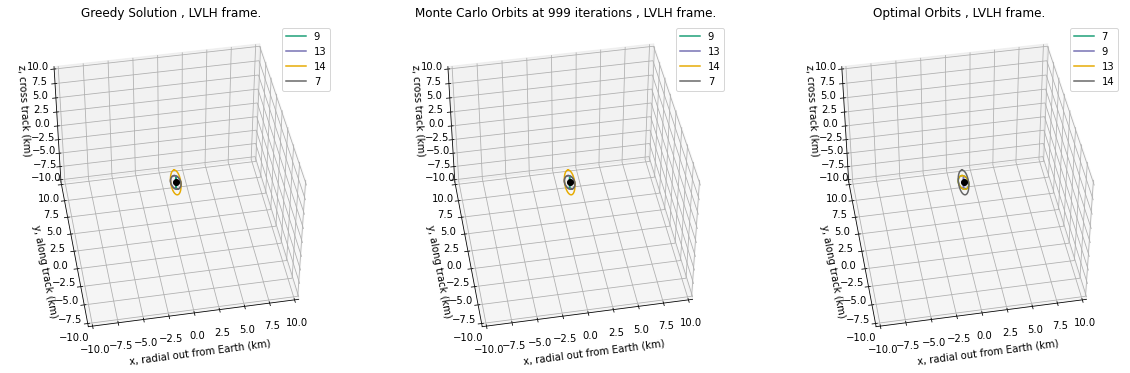

In [181]:
sp, target_size, res = get_config_opt(SELECTED_EXPER, 'config.yaml')
show_solution(SELECTED_EXPER, [sp[0]], 999)

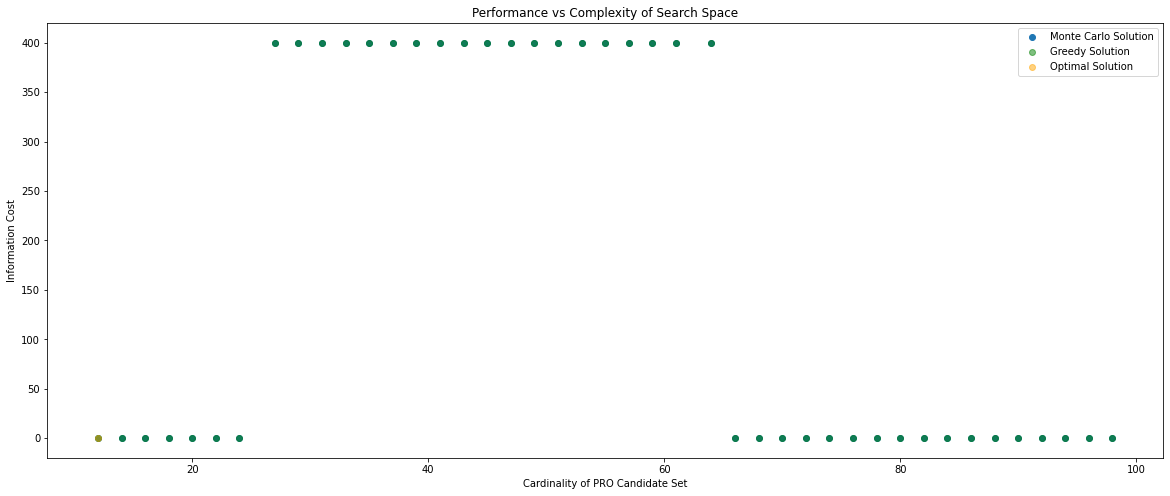

In [190]:
plot_by_complexity(SELECTED_EXPER, 499) # Label axes

#scatter plot?

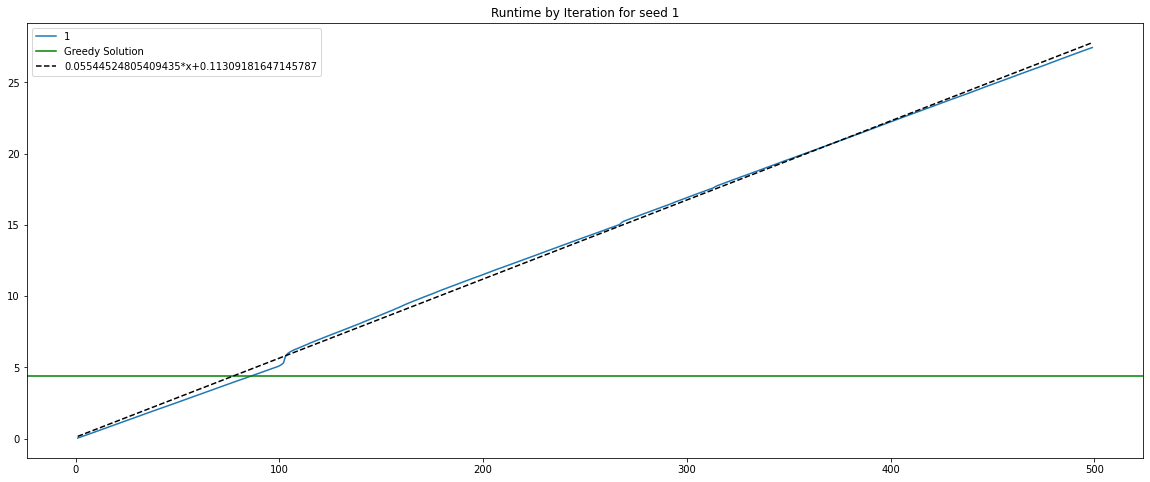

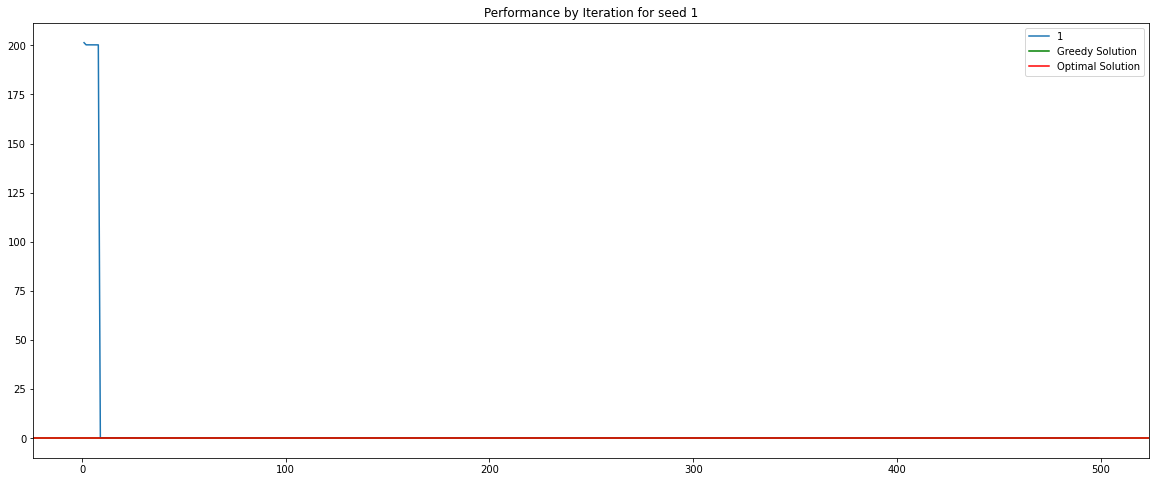

In [191]:
plot_by_iteration(SELECTED_EXPER, sp[0]) # Average for each seed

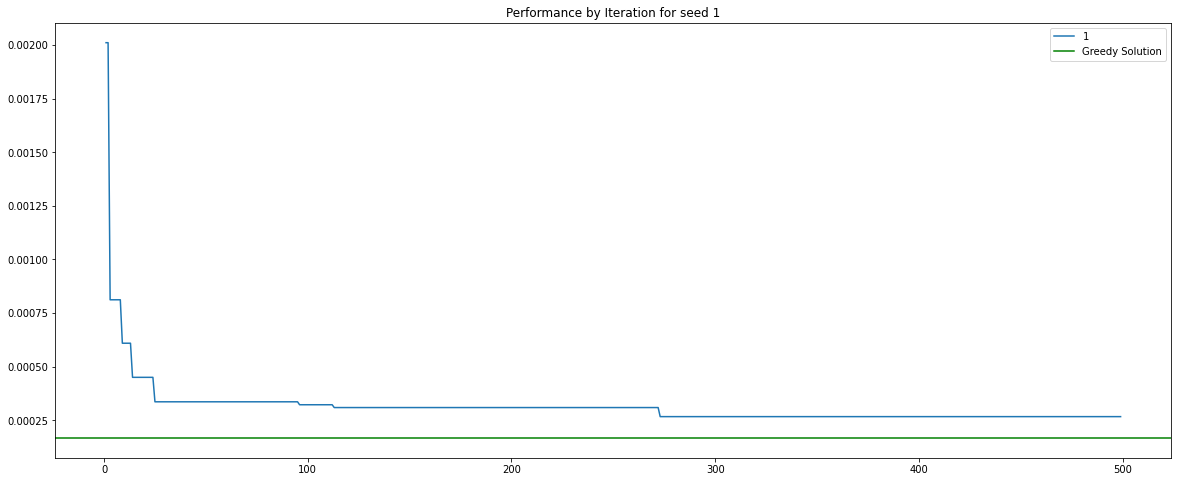

In [27]:
sp, target_size, res = get_config_opt('smaller_orbs', 'config.yaml')
plot_by_iteration('smaller_orbs', sp[0]) # Average for each seed

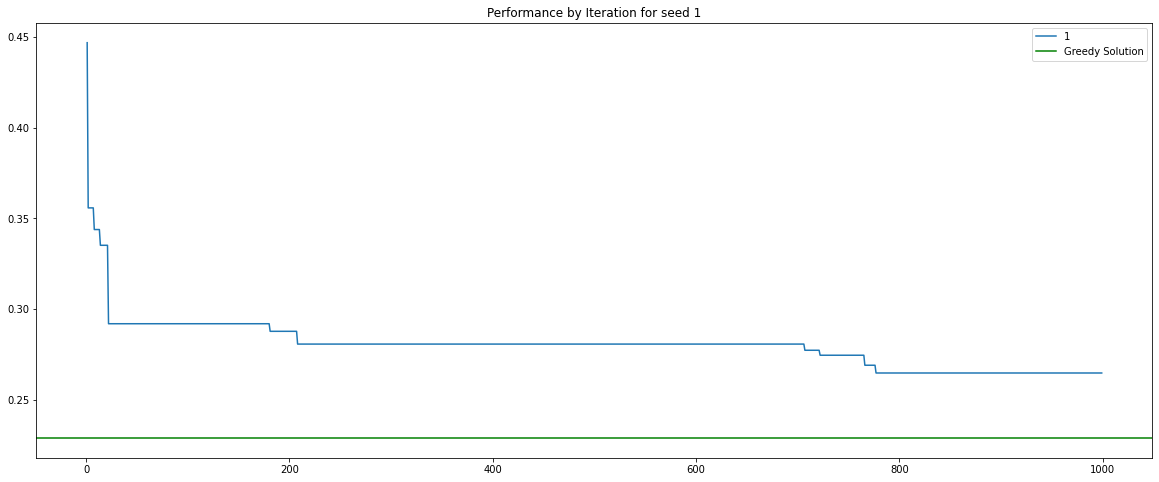

In [16]:
sp, target_size, res = get_config_opt('big_c', 'config.yaml')
plot_by_iteration('big_c', sp[0]) # Average for each seed

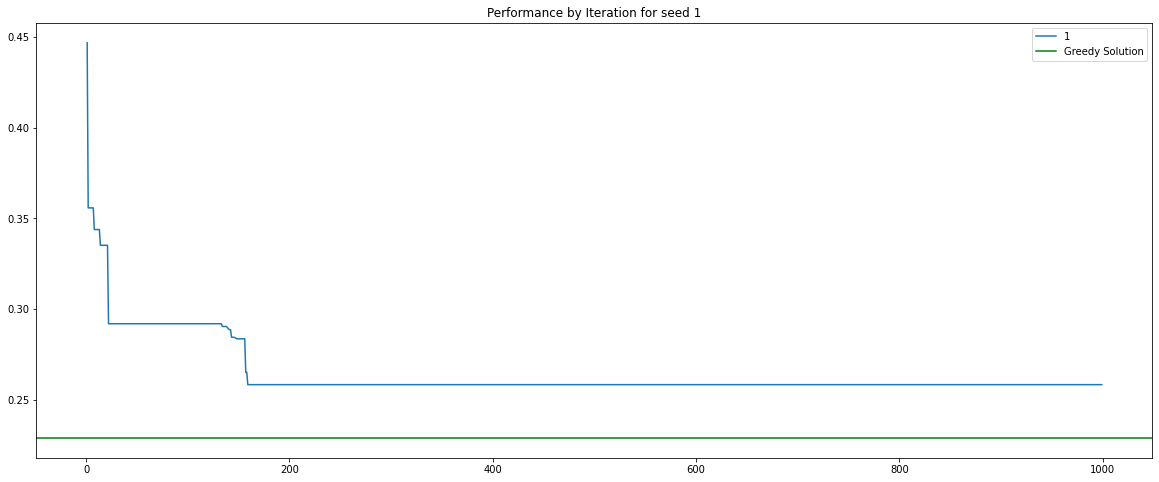

In [17]:
sp, target_size, res = get_config_opt('zero_c', 'config.yaml')
plot_by_iteration('zero_c', sp[0]) # Average for each seed

show observation points
shrink time frame

make trivial problem
    -each orbit makes two observaiton with two points of interests
        - one orbit sees both not well, other two see one orbit very well


choice of W?
    -make it very large


Methods section
    -balance between deatil
    -used UCT how to generate the search space
    -gridding with resolution
    -other parameters
    -why did we choose the search space the size that it is?
        -large enough space to be interesting and small enough to be tractable
        

INTro
    -related work, contributions
    -reformulations
    -